In [ ]:
# 1. Disinstalla tutto
!pip uninstall -y torch torchvision torchaudio

# 2. Reinstalla versione stabile con supporto GPU (se usi Colab con GPU attiva)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet

# 3. (Opzionale) Pulisci cache
!rm -rf ~/.cache/torch_extensions


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 235.3/663.9 MB 196.4 MB/s eta 0:00:03
ERROR: Operation cancelled by user
^C


In [ ]:
!pip install torch --upgrade --quiet


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils
from sklearn.metrics import roc_auc_score
import numpy as np
import os
from PIL import Image

In [2]:
from torchvision.models.segmentation import deeplabv3_resnet50

def get_deeplabv3_multilabel_model(num_classes=8, pretrained=True):
    """
    Returns DeepLabv3 with ResNet50 backbone and sigmoid multi-label head:
    19 known classes + 1 "object" class.
    """
    model = deeplabv3_resnet50(pretrained=pretrained)
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model


In [12]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Project/RoadObstacleDetection(vecchio)/src/dataloaders')


from cityscapes_dataloader import CityscapesObstacleDataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import torchvision.transforms.v2 as Tv2

from torch.utils.data import Subset
resize_dims = (512, 1024)  # immagini più grandi, come richiesto

# 🔁 Trasformazioni randomiche e sincronizzate img+mask
class JointTransform:
    def __init__(self, size=(512, 1024), flip_prob=0.5, jitter=True):
        self.size = size
        self.flip_prob = flip_prob
        self.jitter = jitter
        self.color_jitter = Tv2.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.05
        )

    def __call__(self, img, mask):
        # Resize immagine e maschera
        img = F.resize(img, self.size, antialias=True)
        # CORRETTO
        mask = F.resize(mask.unsqueeze(0), self.size, interpolation=F.InterpolationMode.NEAREST).squeeze(0)

        # Flip orizzontale con probabilità 0.5
        if random.random() < self.flip_prob:
            img = F.hflip(img)
            mask = F.hflip(mask)

        # Color jitter solo sull'immagine (non sulla maschera!)
        if self.jitter:
            img = self.color_jitter(img)

        return img, mask

joint_transform = JointTransform(size=resize_dims, flip_prob=0.5, jitter=True)


# Trasformazione specifica per immagine (normalizzazione)
img_transform = Tv2.Compose([
    Tv2.ToImage(),  # se l'immagine è PIL o numpy
    Tv2.ToDtype(torch.float32, scale=True),
    Tv2.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
])

# Trasformazione specifica per maschera
mask_transform = Tv2.Compose([
    Tv2.ToDtype(torch.int64),  # class mask deve restare intera
])

root_path = "/content/drive/MyDrive/Project/RoadObstacleDetection(vecchio)/Datasets/leftImg8bit_trainvaltest"




# --- Dataset di validazione ---
val_dataset = CityscapesObstacleDataset(
    root= root_path,
    split='val',
    img_transform=img_transform,
    joint_transform=joint_transform,
    mask_transform=mask_transform
)



# 4. Dataset + Dataloader
train_dataset = CityscapesObstacleDataset(
    root=root_path,
    split='train',
    img_transform=img_transform, # Initial transform, augmentation will be applied in __getitem__
    joint_transform=joint_transform,
    mask_transform=mask_transform # Initial transform, augmentation will be applied in __getitem__
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    drop_last=True  # per evitare batch di dimensione 1
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False
)



🧭 Path immagini: /content/drive/MyDrive/Project/RoadObstacleDetection(vecchio)/Datasets/leftImg8bit_trainvaltest/leftImg8bit_trainvaltest/leftImg8bit/val
🧭 Path maschere: /content/drive/MyDrive/Project/RoadObstacleDetection(vecchio)/Datasets/leftImg8bit_trainvaltest/gtFine_trainvaltest/gtFine/val
🧭 Path immagini: /content/drive/MyDrive/Project/RoadObstacleDetection(vecchio)/Datasets/leftImg8bit_trainvaltest/leftImg8bit_trainvaltest/leftImg8bit/train
🧭 Path maschere: /content/drive/MyDrive/Project/RoadObstacleDetection(vecchio)/Datasets/leftImg8bit_trainvaltest/gtFine_trainvaltest/gtFine/train


In [ ]:
print("✅ Numero immagini:", len(train_dataset))
print("🔍 Primo path immagine:", train_dataset.img_paths[0])
print("🔍 Primo path maschera (gtFine):", train_dataset.mask_paths[0])


In [5]:
from torchvision.transforms.v2 import functional as F


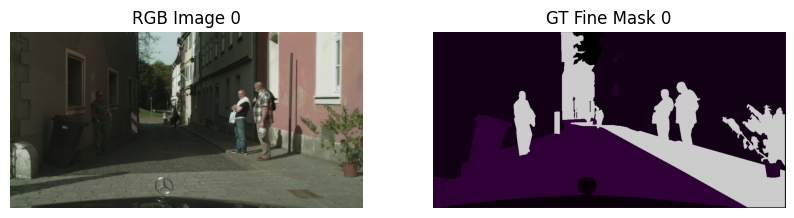

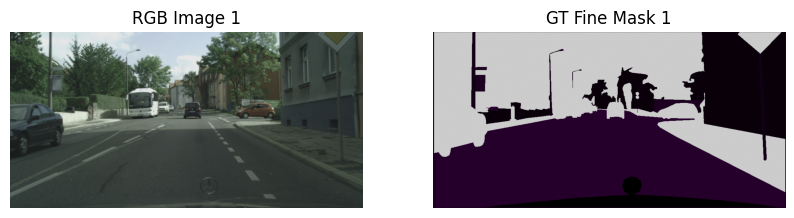

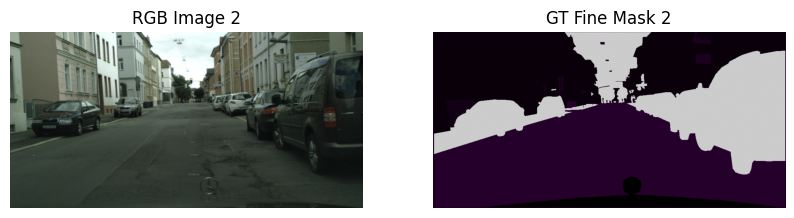

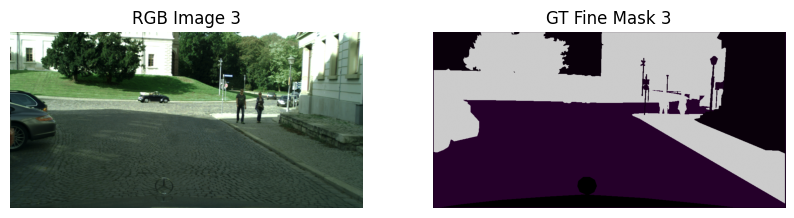

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import random

import numpy as np

# Quante immagini vuoi visualizzare?
N = 4

# Prendi le prime N immagini e maschere dal dataset
for i in range(N):
    sample = train_dataset[i]  # oppure val_dataset[i] se vuoi quelle di validation

    image = sample['image']        # Tensor normalizzato
    mask = sample['class_mask']    # Maschera semantica (valori 0–33)

    # Converti da tensor a numpy per visualizzare
    img_np = image.permute(1, 2, 0).numpy()  # da [C,H,W] a [H,W,C]
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # de-normalizza
    img_np = np.clip(img_np, 0, 1)

    mask_np = mask.numpy()

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title(f"RGB Image {i}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(mask_np, cmap='nipy_spectral')
    plt.title(f"GT Fine Mask {i}")
    plt.axis('off')

    plt.show()


In [6]:
def compute_iou(preds, masks, threshold=0.5):
    preds_bin = (preds > threshold).float()
    intersection = (preds_bin * masks).sum().item()
    union = ((preds_bin + masks) > 0).float().sum().item()
    return intersection, union


In [7]:
def evaluate(model, dataloader, device, save_preds=False, save_dir="predictions"):
    print("🔍 Entrata in evaluate()")
    print(f"Numero batch in dataloader: {len(dataloader)}")

    model.eval()
    intersection_total = 0.0
    union_total = 0.0
    total_auroc = 0.0
    all_preds = []
    all_targets = []

    if save_preds:
        os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
         for i, batch in enumerate(dataloader):
            print(f"🧪 Batch {i+1}/{len(dataloader)}")
            images = batch['image'].to(device)
            masks = batch['object_mask'].float().to(device)

            outputs = model(images)['out']  # [B, 8, H, W]
            object_logits = outputs[:, 7, :, :]
            probs = torch.sigmoid(object_logits)

            try:
                inter, uni = compute_iou(probs, masks)
                intersection_total += inter
                union_total += uni
            except Exception as e:
                print(f"⚠️ Errore in compute_iou: {e}")
                continue



            all_preds.append(probs.cpu().flatten())
            all_targets.append(masks.cpu().flatten())

            # Save predictions
            if save_preds:
                for j in range(images.size(0)):
                    pred_mask = (probs[j] > 0.5).cpu().numpy() * 255
                    pred_img = Image.fromarray(pred_mask.astype(np.uint8))
                    pred_img.save(os.path.join(save_dir, f"pred_{i}_{j}.png"))

    if not all_preds:
        print("❌ Nessun batch elaborato — controllo dataloader.")
        return 0.0, 0.0

    print(f"📏 AUROC input size: {len(all_preds)} predizioni")

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    try:
        total_auroc = roc_auc_score(all_targets, all_preds)
    except ValueError:
        total_auroc = 0.0  # In caso tutte le label siano uguali

    avg_iou = intersection_total / union_total if union_total > 0 else 0.0

    print(f"📊 Evaluation — IoU: {avg_iou:.4f}, AUROC: {total_auroc:.4f}")

    return avg_iou, total_auroc


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_deeplabv3_multilabel_model(num_classes=8, pretrained=True).to(device)

# LOSS con lambda = 3
# Define multi-label sigmoid loss: one for object_mask, one for class_mask
bce_loss = nn.BCEWithLogitsLoss()
ce_loss = nn.CrossEntropyLoss(ignore_index=255)

# SGD optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

# poly scheduler funzione
def poly_lr_scheduler(optimizer, init_lr, iter, max_iter, power=0.9):
    new_lr = init_lr * (1 - iter / max_iter) ** power
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 222MB/s]


In [ ]:
print("✅ Numero immagini:", len(train_dataset))
print("🔍 Primo path immagine:", train_dataset.img_paths[0])
print("🔍 Primo path maschera (gtFine):", train_dataset.mask_paths[0])


In [15]:
import time
import random # Import random for scaling

epochs = 1
max_iter = len(train_dataloader) * epochs
global_iter = 0
accumulation_steps = 4 # Gradient accumulation steps

train_losses = []
val_ious = []
val_aurocs = []

print(f"🟢 Inizio training per {epochs} epoche")
print(f"📦 Batches per epoca: {len(train_dataloader)}")

for epoch in range(epochs):
    model.train()
    total_loss = 0
    start_epoch = time.time()

    # Apply random scaling at the beginning of each epoch
    scale_factor = random.uniform(0.5, 2.0)
    print(f"📐 Scaling factor for epoch {epoch+1}: {scale_factor:.4f}")
    train_dataset.current_scale_factor = scale_factor


    print(f"\n🚀 Epoch {epoch+1}/{epochs} iniziata...")

    optimizer.zero_grad() # Zero gradients before accumulation loop

    for i, batch in enumerate(train_dataloader):
        images = batch['image'].to(device)

        start_batch = time.time()

        if images.shape[0] == 1:
            print(f"⚠️ Batch {i} ignorato (batch size = 1)")
            continue

        object_mask = batch['object_mask'].to(device).float()
        class_mask = batch['class_mask'].to(device).long()

        print(f"🧩 Image shape at batch {i}: {images.shape}")

        outputs = model(images)['out']  # shape: (B, 8, H, W)

        object_logits = outputs[:, 7, :, :]  # channel 7 → object
        class_logits = outputs[:, :7, :, :]  # channels 0–6 → macro-classes

        loss_obj = bce_loss(object_logits, object_mask)
        loss_cls = ce_loss(class_logits, class_mask)

        loss = loss_obj + loss_cls
        loss = loss / accumulation_steps # Normalize loss for accumulation
        loss.backward()
        total_loss += loss.item() * accumulation_steps # Scale loss back for reporting

        global_iter += 1

        # Perform optimizer step every accumulation_steps
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad() # Zero gradients after step

        # 🔁 Stampa ogni 10 batch
        if i % 10 == 0:
            print(f"  🧱 Batch {i}/{len(train_dataloader)} | Loss: {loss.item()*accumulation_steps:.4f} | Time: {time.time() - start_batch:.2f}s")

    # Perform optimizer step for remaining gradients
    if (len(train_dataloader) % accumulation_steps) != 0:
        optimizer.step()

    print(f"✅ Fine epoch {epoch+1}/{epochs} | Total Loss: {total_loss:.4f} | Time: {time.time() - start_epoch:.2f}s")

    train_losses.append(total_loss)

    # Valutazione su validation set
    print(f"🔍 Valutazione su validation set...")
    iou, auroc = evaluate(
        model,
        val_loader,
        device,
        save_preds=False
    )
    print(f"📊 Val IOU: {iou:.4f} | AUROC: {auroc:.4f}")

    val_ious.append(iou)
    val_aurocs.append(auroc)

# Salvataggio finale
save_path = "/content/drive/MyDrive/Project/ckpts/deeplabv3_binary_cityscapes.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"💾 Modello salvato in: {save_path}")

🟢 Inizio training per 1 epoche
📦 Batches per epoca: 1487
📐 Scaling factor for epoch 1: 1.5678

🚀 Epoch 1/1 iniziata...
🧩 Image shape at batch 0: torch.Size([2, 3, 512, 1024])
  🧱 Batch 0/1487 | Loss: 1.1958 | Time: 0.13s
🧩 Image shape at batch 1: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 2: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 3: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 4: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 5: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 6: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 7: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 8: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 9: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 10: torch.Size([2, 3, 512, 1024])
  🧱 Batch 10/1487 | Loss: 0.8076 | Time: 0.13s
🧩 Image shape at batch 11: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 12: torch.Size([2, 3, 512, 1024])
🧩 Image shape at batch 13: torch.Size([2, 3, 512, 1024])


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Project/RoadObstacleDetection(vecchio)/Datasets/leftImg8bit_trainvaltest/leftImg8bit_trainvaltest/leftImg8bit/train/bochum/bochum_000000_027057_leftImg8bit.png'

In [11]:
import os

file_path = '/content/drive/MyDrive/Project/RoadObstacleDetection/Datasets/leftImg8bit_trainvaltest/gtFine_trainvaltest/gtFine/train/aachen/aachen_000019_000019_gtFine_labelIds.png'
print("Esiste il file?", os.path.exists(file_path))


Esiste il file? False


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(sample, probs, threshold=0.5):
    img = sample['image'].permute(1, 2, 0).cpu().numpy()
    # De-normalizza
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = img.clip(0,1)

    gt_mask = sample['object_mask'].cpu().numpy()
    pred_mask = (probs > threshold).cpu().numpy()

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("Immagine")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(gt_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predizione")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

    plt.show()


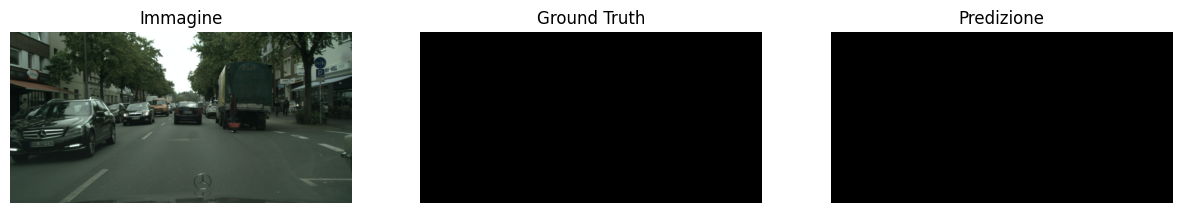

In [14]:
# Prendi un batch dal val_loader
batch = next(iter(val_loader))

images = batch['image']
masks = batch['object_mask']

# Fai la predizione con il modello in modalità eval
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))['out']
    object_logits = outputs[:, 7, :, :]
    probs = torch.sigmoid(object_logits).cpu()

# Visualizza il primo esempio
visualize_prediction(
    { 'image': images[2], 'object_mask': masks[2] },
    probs[2],
    threshold=0.5
)
